In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math

In [3]:
#ANES objects
anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')

filename = "anes_questions.json"
with open(filename, "r") as f:
    questions = json.load(f)

# Question had an option for free text answer, which is not useful for the analysis
# turned into negative value to not take it into account
anes['V201336'].replace(5, -7, inplace=True)

questcode_topic = {"V201336": "abortion1",
              "V201342x": "abortion2",
              "V202332": "climate change1",
              "V202333": "climate change2",
              "V202337": "gun control1",
              "V202341x": "gun control2",
              "V202344x": "gun control3",
              "V202232": "immigration1",
              "V202233": "immigration2",
              "V202236x":"immigration3",
              "V202380x": "healthcare1"}

C:\Users\agust\AppData\Local\Temp\ipykernel_21092\1458618344.py:2: DtypeWarning: Columns (15,17,18,19,21,22,23,25,26,27,29,30,31,33,34,35,37,38,1508,1509) have mixed types. Specify dtype option on import or set low_memory=False.
  anes = pd.read_csv('anes_timeseries_2020_csv_20220210.csv')


In [4]:
#Result objects OpenAI
filename = "openai_zero_results.json"
with open(filename, "r") as f:
    openai_ans_zero = json.load(f)

filename = "openai_comments_results.json"
with open(filename, "r") as f:
    openai_ans_comments = json.load(f)

filename = "openai_comments_strict_results.json"
with open(filename, "r") as f:
    openai_ans_comments_strict = json.load(f)

#openai_ans_zero, openai_ans_comments, openai_ans_comments_strict

#Result objects OS


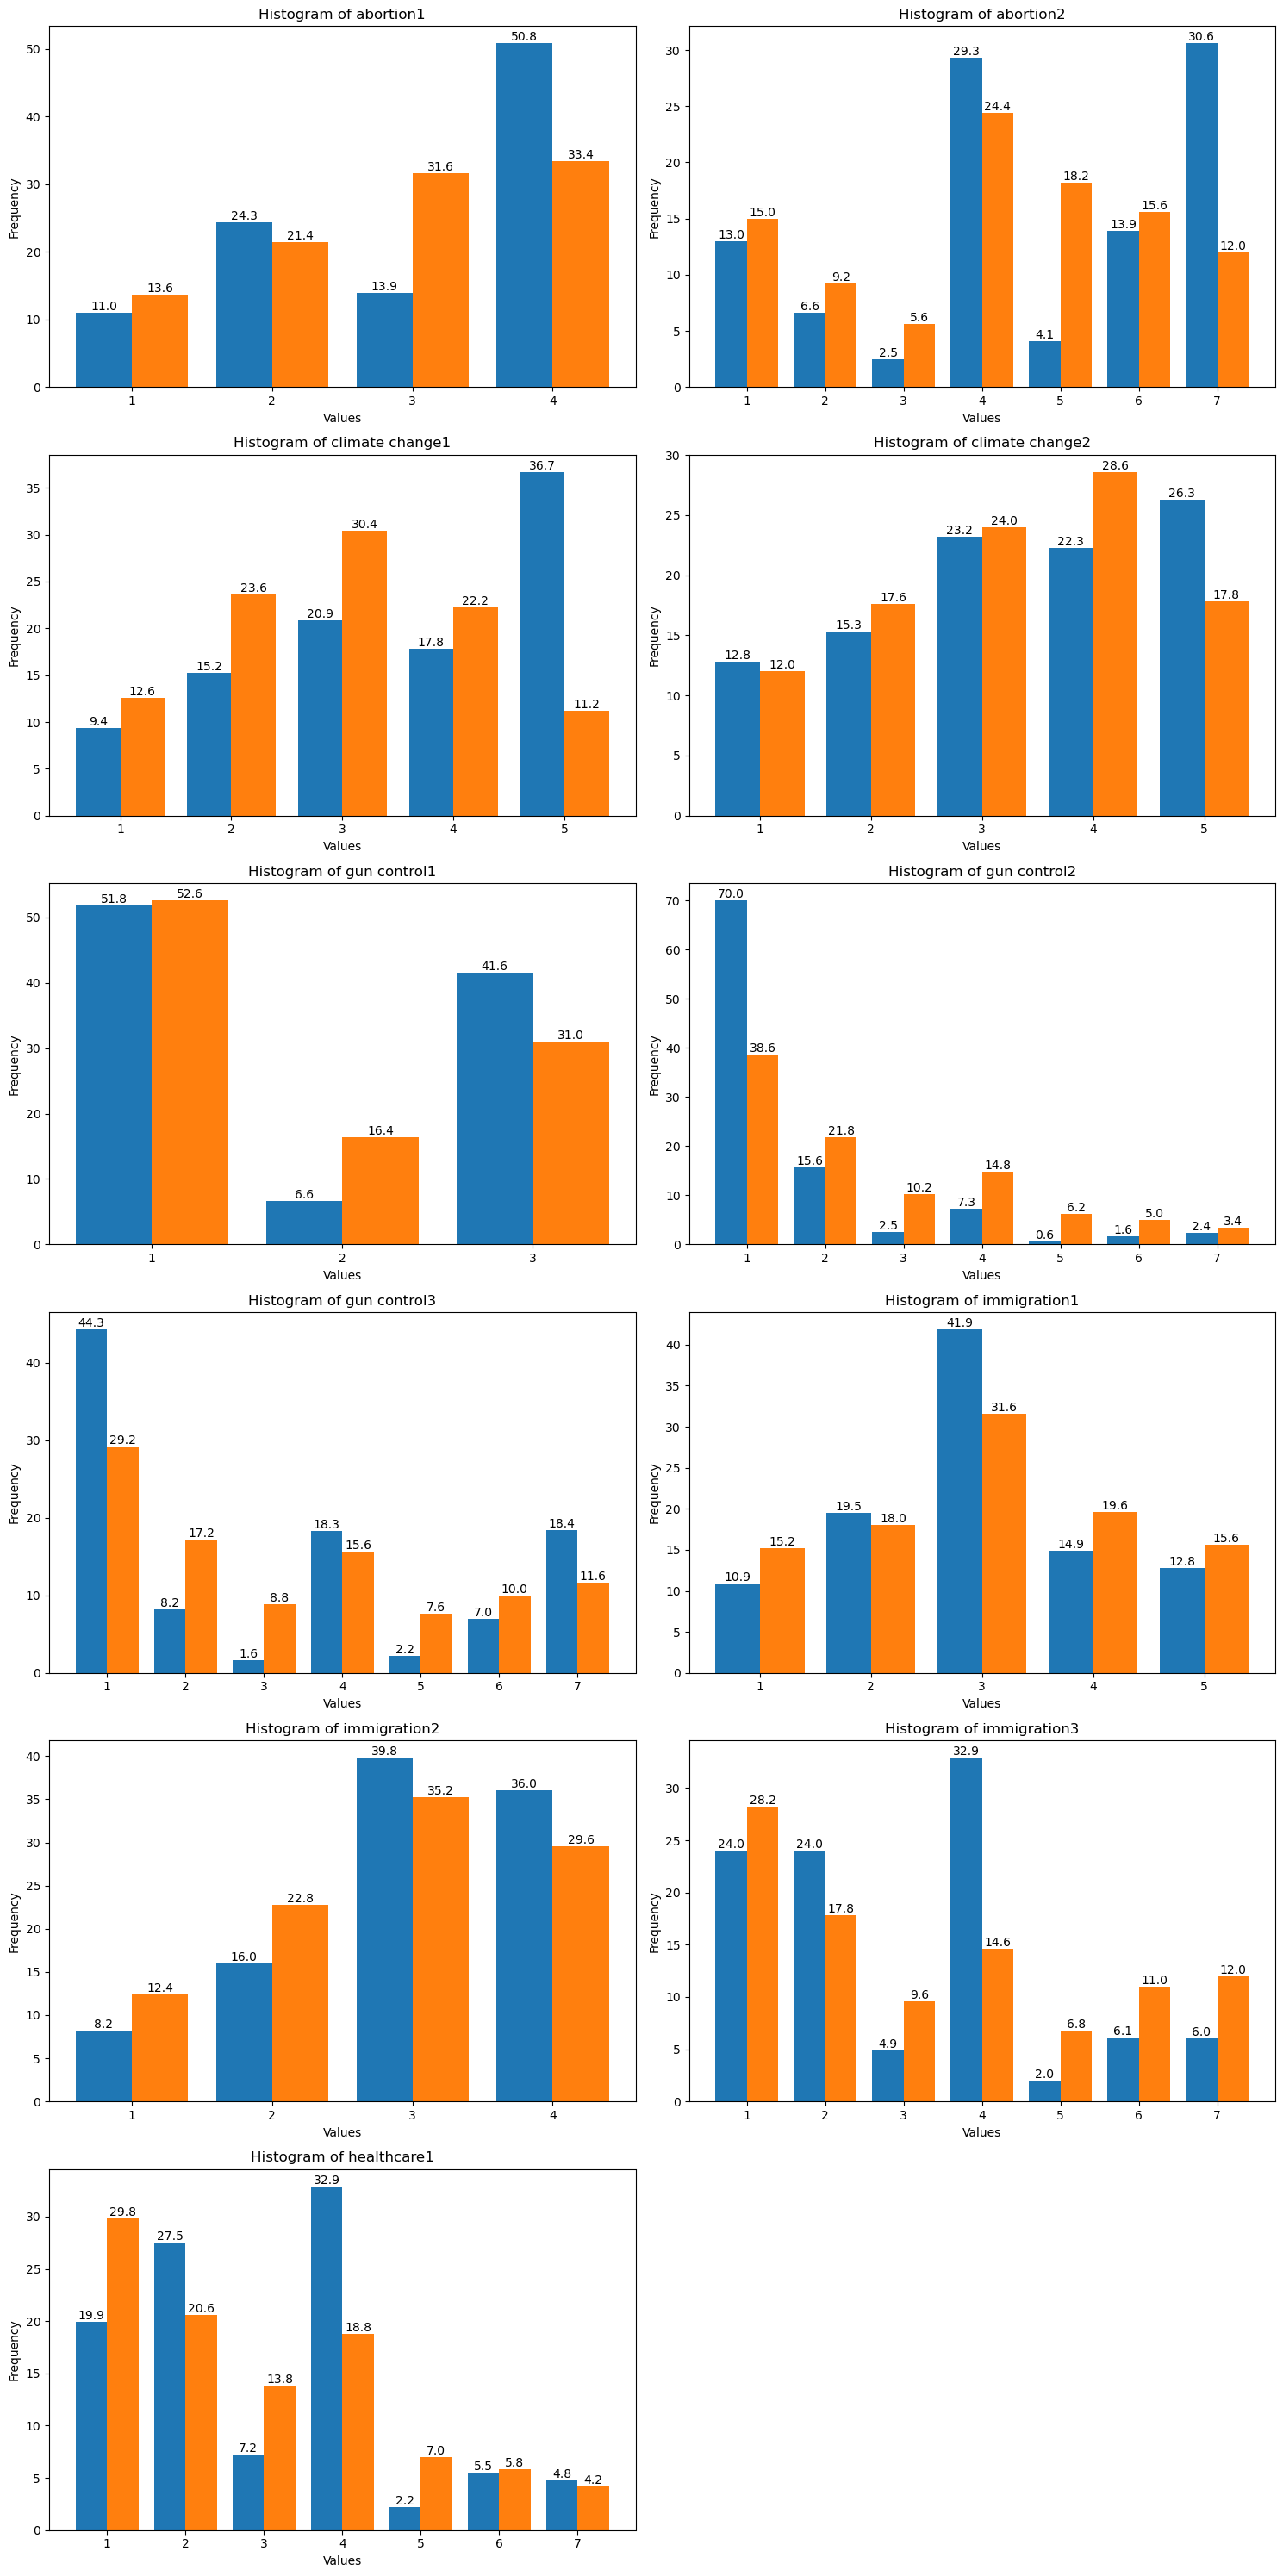

In [12]:
num_plots = len(questcode_topic)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)  # Round up to the nearest integer
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for idx, (key, values) in enumerate(questcode_topic.items()):
    try:
        valid_ans = anes[anes[key] > 0]
        issue = questcode_topic[key]

        # Calculate number of unique answers
        num_answers = len(valid_ans[key].unique())
        counts_ai = openai_ans_zero[key][-1].values() #5 runs and average is in last position

        labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
        percentages = np.around((counts / np.sum(counts)) * 100, 1)
        bar_width = 0.4

        row = idx // num_cols
        col = idx % num_cols

        axs[row, col].bar(labels - bar_width/2, percentages, width=bar_width, align='center')
        axs[row, col].bar(labels + bar_width/2, counts_ai, width=bar_width, align='center')

        axs[row, col].set_xticks(labels)

        for label, count in zip(labels, percentages):
            axs[row, col].text(label - bar_width/2, count, str(count), ha='center', va='bottom')
        for label, count in zip(labels, counts_ai):
            axs[row, col].text(label + bar_width/2, count, str(count), ha='center', va='bottom')

        axs[row, col].set_title('Histogram of {}'.format(issue))
        axs[row, col].set_xlabel('Values')
        axs[row, col].set_ylabel('Frequency')

    except Exception as e:
        print(f"Error in plotting {issue}: {e}")

# Remove empty subplots
for i in range(num_plots, num_rows*num_cols):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()

In [7]:
def bootstrap(data, num_iterations=1000):
    bootstrapped_means = []
    bootstrapped_stds = []
    total_samples = np.sum(data)
    for _ in range(num_iterations):
        bootstrap_sample = np.random.choice(np.arange(1, len(data) + 1), size=int(total_samples), replace=True, p=data/np.sum(data))
        bootstrapped_means.append(np.mean(bootstrap_sample))
        bootstrapped_stds.append(np.std(bootstrap_sample))
        
    return bootstrapped_means, bootstrapped_stds

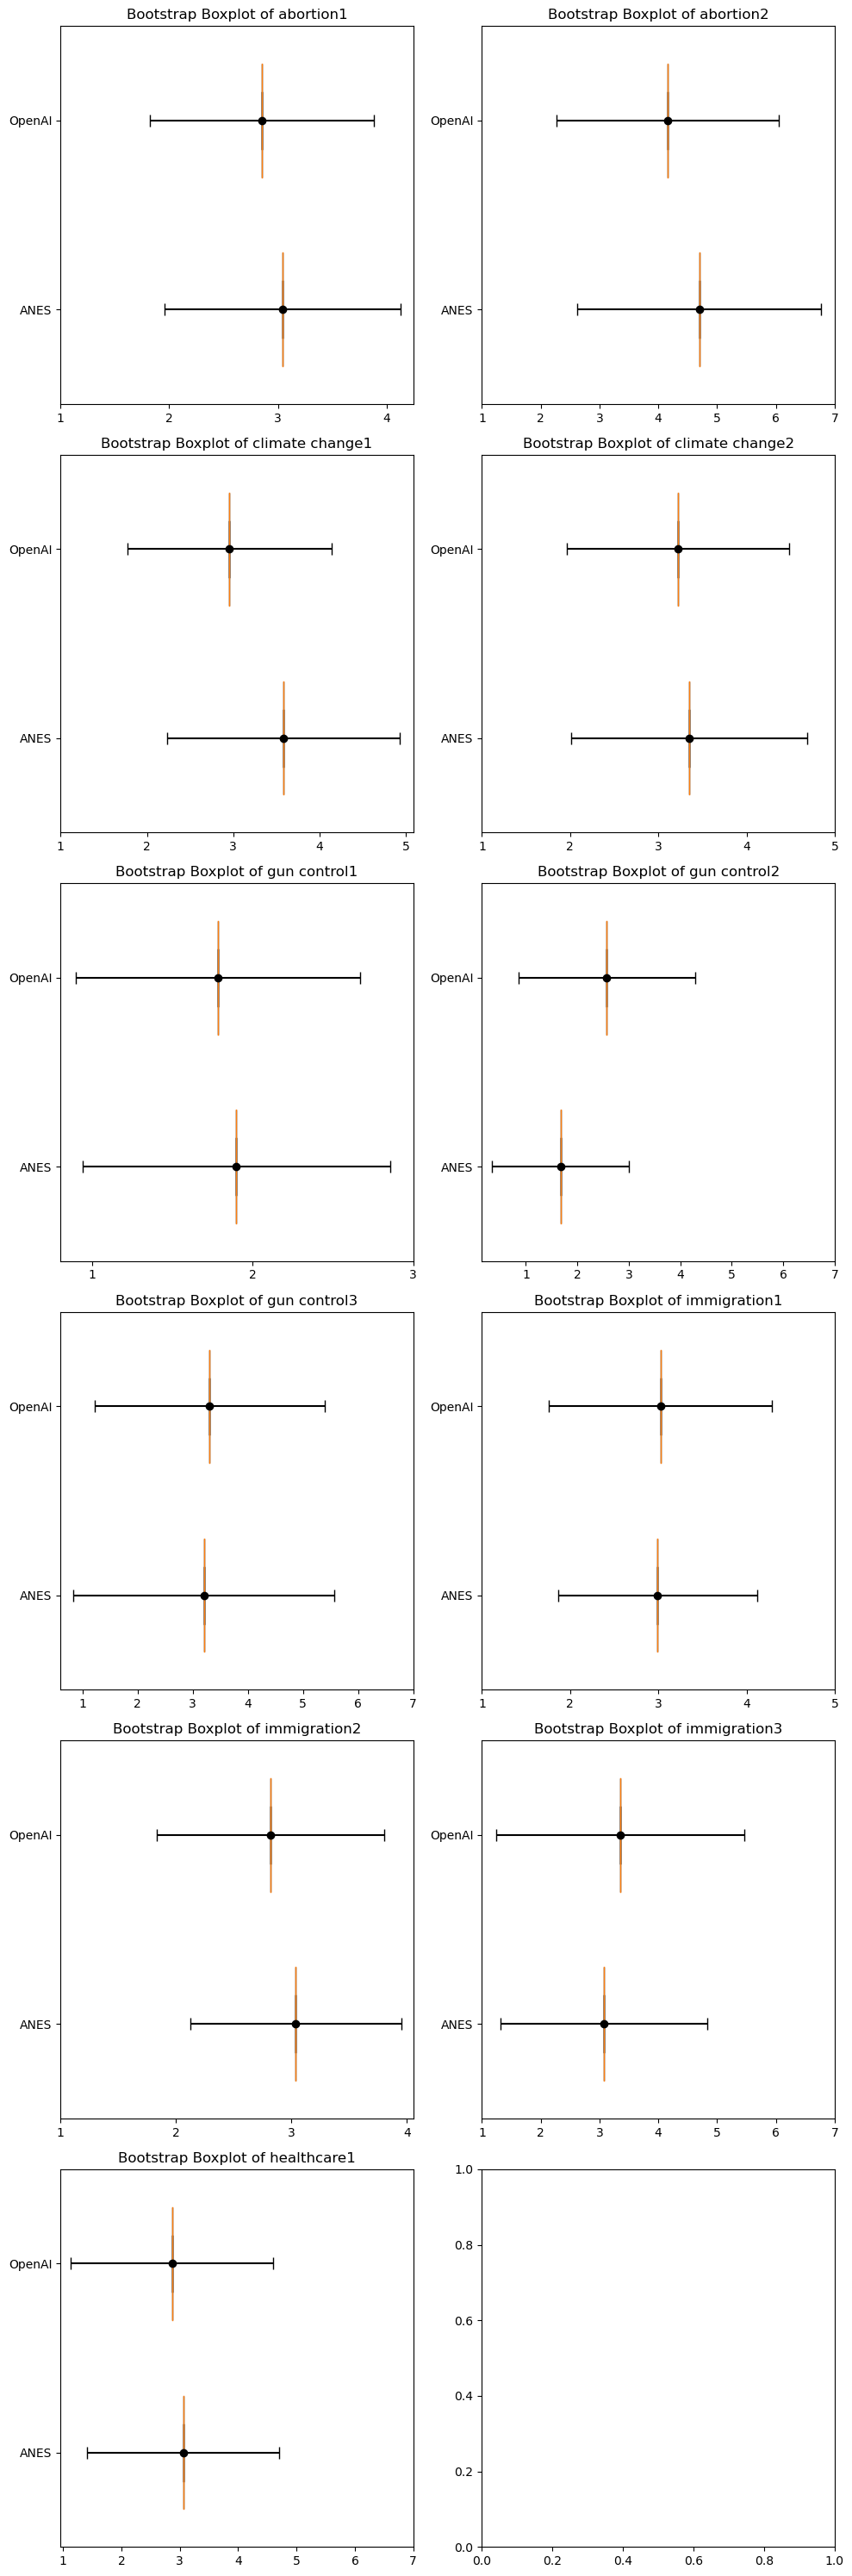

In [11]:
num_plots = len(questcode_topic)
num_cols = 2
num_rows = math.ceil(num_plots / num_cols)  # Round up to the nearest integer
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

for idx, (key, issue) in enumerate(questcode_topic.items()):
        
        #Extract Anes data results
        valid_ans = anes[anes[key] > 0]
        #num_answers = len(valid_ans[key].unique())
        labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
        counts_anes = np.around((counts / np.sum(counts)) * 100, 1)        
        #Extract OpenAI data results
        counts_ai = np.array(list(openai_ans_zero[key][-1].values()))  # Ensure one-dimensional array

        # Perform bootstrap for OpenAI and ANES data
        bootstrapped_means_anes, std_anes = bootstrap(counts_anes)
        bootstrapped_means_ai, std_ai = bootstrap(counts_ai)

        # Calculate mean and standard deviation
        mean_anes = np.mean(bootstrapped_means_anes)
        mean_ai = np.mean(bootstrapped_means_ai)
        mean_std_anes = np.mean(std_anes)
        mean_std_ai = np.mean(std_ai)
        
        row = idx // num_cols
        col = idx % num_cols

        # Plot boxplots with error bars for OpenAI and ANES
        axs[row, col].boxplot([[mean_anes], [mean_ai]], vert=False, positions=[0, 1], widths=0.6, patch_artist=True)
        axs[row, col].errorbar([mean_anes, mean_ai], [0, 1], xerr=[mean_std_anes, mean_std_ai], fmt='o', color='black', capsize=5)
        axs[row, col].set_yticks([0, 1])
        axs[row, col].set_yticklabels(['ANES', 'OpenAI'])

        axs[row, col].set_xticks(np.arange(1, len(counts_anes) + 1))
        axs[row, col].set_title('Bootstrap Boxplot of {}'.format(issue))

plt.tight_layout()
plt.show()


In [15]:
mean_var = {}

for key, value in questions.items():
    # Only include valid answers
    valid = anes[anes[key] > 0]
    # frequencies = valid[key].value_counts()
    column_mean = valid[key].mean()
    column_var = valid[key].var()
    num_respondents = len(valid[key])
    mean_var[key] = [column_mean, column_var, num_respondents]
    
mean_var

{'V201336': [3.119030214424951, 1.282893564092481, 8208],
 'V201342x': [4.689327485380117, 4.338709039566053, 8208],
 'V202332': [3.5717382468500203, 1.8473258263269425, 7381],
 'V202333': [3.340511986997156, 1.825786082997807, 7383],
 'V202337': [1.89735593220339, 0.9236911365172453, 7375],
 'V202341x': [1.6703668607012319, 1.812394165422136, 7387],
 'V202344x': [3.207424468229237, 5.664150831861712, 7381],
 'V202232': [2.9915646258503403, 1.2937103016468015, 7350],
 'V202233': [3.0364054675869534, 0.8464005047669663, 7389],
 'V202236x': [3.072867378667027, 3.1129968202944625, 7397],
 'V202380x': [3.0557224801966676, 2.7443334555495578, 7322]}

In [43]:
from scipy.stats import mannwhitneyu
#from scipy.stats import rankbiserialr

# Number of tests
num_tests = len(openai_ans_zero.keys())

# Dictionary to store results
results_dict = {}

# Loop over each key in openai_ans_zero
for key in openai_ans_zero:
    # Get the values from openai_ans_zero for the current key
    openai_values = np.array(list(openai_ans_zero[key][-1].values()))
    
    # Get the percentages from valid_ans for the current key
    valid_ans = anes[anes[key] > 0]
    labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
    anes_values = np.around((counts / np.sum(counts)) * 100, 1)

    # Perform Mann-Whitney U test
    u_statistic, p_value = mannwhitneyu(openai_values, anes_values, alternative='two-sided')
    
    # Correct p-value for multiple tests using Bonferroni correction
    corrected_p_value = p_value * num_tests
    
    
    # Calculate Cliff's delta
    delta = (np.sum(np.sign(np.subtract.outer(openai_values, anes_values))) / (len(openai_values) * len(anes_values)))

    # Store results in dictionary
    results_dict[key] = {
        'u_statistic': u_statistic,
        'p_value': p_value,
        'corrected_p_value': corrected_p_value,
        'delta': delta
    }

In [44]:
results_dict

{'V201336': {'u_statistic': 9.0,
  'p_value': 0.8857142857142857,
  'corrected_p_value': 9.742857142857142,
  'delta': 0.125},
 'V201342x': {'u_statistic': 28.0,
  'p_value': 0.7103729603729605,
  'corrected_p_value': 7.814102564102566,
  'delta': 0.14285714285714285},
 'V202332': {'u_statistic': 14.0,
  'p_value': 0.8412698412698413,
  'corrected_p_value': 9.253968253968255,
  'delta': 0.12},
 'V202333': {'u_statistic': 13.0,
  'p_value': 1.0,
  'corrected_p_value': 11.0,
  'delta': 0.04},
 'V202337': {'u_statistic': 5.0,
  'p_value': 1.0,
  'corrected_p_value': 11.0,
  'delta': 0.1111111111111111},
 'V202341x': {'u_statistic': 34.0,
  'p_value': 0.25932400932400934,
  'corrected_p_value': 2.8525641025641026,
  'delta': 0.3877551020408163},
 'V202344x': {'u_statistic': 29.0,
  'p_value': 0.6200466200466201,
  'corrected_p_value': 6.820512820512821,
  'delta': 0.1836734693877551},
 'V202232': {'u_statistic': 17.0,
  'p_value': 0.42063492063492064,
  'corrected_p_value': 4.6269841269841

In [40]:
for key in openai_ans_zero:
    # Get the values from openai_ans_zero for the current key
    openai_values = np.array(list(openai_ans_zero[key][-1].values()))
    
    # Get the percentages from valid_ans for the current key
    valid_ans = anes[anes[key] > 0]
    labels, counts = np.unique(valid_ans[key].to_numpy(), return_counts=True)
    anes_values = np.around((counts / np.sum(counts)) * 100, 1)
    

    print(f"Open AI Value: {openai_values}, Anes Value: {anes_values}")

Open AI Value: [13.6 21.4 31.6 33.4], Anes Value: [11.  24.3 13.9 50.8]
Open AI Value: [15.   9.2  5.6 24.4 18.2 15.6 12. ], Anes Value: [13.   6.6  2.5 29.3  4.1 13.9 30.6]
Open AI Value: [12.6 23.6 30.4 22.2 11.2], Anes Value: [ 9.4 15.2 20.9 17.8 36.7]
Open AI Value: [12.  17.6 24.  28.6 17.8], Anes Value: [12.8 15.3 23.2 22.3 26.3]
Open AI Value: [52.6 16.4 31. ], Anes Value: [51.8  6.6 41.6]
Open AI Value: [38.6 21.8 10.2 14.8  6.2  5.   3.4], Anes Value: [70.  15.6  2.5  7.3  0.6  1.6  2.4]
Open AI Value: [29.2 17.2  8.8 15.6  7.6 10.  11.6], Anes Value: [44.3  8.2  1.6 18.3  2.2  7.  18.4]
Open AI Value: [15.2 18.  31.6 19.6 15.6], Anes Value: [10.9 19.5 41.9 14.9 12.8]
Open AI Value: [12.4 22.8 35.2 29.6], Anes Value: [ 8.2 16.  39.8 36. ]
Open AI Value: [28.2 17.8  9.6 14.6  6.8 11.  12. ], Anes Value: [24.  24.   4.9 32.9  2.   6.1  6. ]
Open AI Value: [29.8 20.6 13.8 18.8  7.   5.8  4.2], Anes Value: [19.9 27.5  7.2 32.9  2.2  5.5  4.8]
